# NBA Game Dashboard Design Outline

# Game Context

- away @ home
- total / spread

# Team Context

- record / L10 record
- injuries
    - players returning from injuries 
    - starting lineups ?
    - highlight key scorers / defenders
- stats allowed (overall + dvp)
- pace(rank) ?

# Player Context

- PTS, REB, AST (+ projection)
    - FPS
    - 3s
        - REB/AST chance data

- hot / cold n-game streak
    - x out of last y
    - season hit %
    - visualize outcomes vs szn/rolling avg
        - visualize attempts/chances
- baseline deviation ?
- matchup
- stats without injured teammate
- home / away splits
- H2H performances

- Similar player recently recorded stats
- Recent scoring/assist performances vs game totals 

In [108]:
home_team = "New Orleans Pelicans"
home = "NOP"
away_team = "Los Angeles Lakers"
away = "LAL"
game_total = 235
home_spread = -6
away_spread = 6

print(f"{away_team} @ {home_team}")
print(f"Game total: {game_total}")
print(f"Spreads:\n  Away: {away_spread}\n  Home: {home_spread}")

Los Angeles Lakers @ New Orleans Pelicans
Game total: 235
Spreads:
  Away: 6
  Home: -6


In [2]:
# Connect to database
from sqlalchemy import create_engine
import pandas as pd

DB_USER = "admin"
DB_PASSWORD = "admin"
DB_HOST = "localhost"
DB_PORT = 5433
DB_NAME = "nba_db"

engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

In [3]:
query = """
ALTER TABLE boxscores.player_boxscores_traditional_v3
ADD COLUMN IF NOT EXISTS clean_name TEXT;

UPDATE boxscores.player_boxscores_traditional_v3
SET clean_name = regexp_replace(
    lower(unaccent(CONCAT_WS(' ', first_name, family_name))),
    '[^a-z ]',
    '',
    'g'
);

SELECT 
    *,
    AVG(points) OVER (
        PARTITION BY player_id
        ORDER BY game_id
        ROWS BETWEEN UNBOUNDED PRECEDING AND 1 PRECEDING
    ) AS ppg,
    AVG(points) OVER(
        PARTITION BY player_id
        ORDER BY game_id
        ROWS BETWEEN 10 PRECEDING AND 1 PRECEDING
    ) AS r10_ppg
FROM boxscores.player_boxscores_traditional_v3
WHERE clean_name = 'luka doncic'
"""

pd.read_sql(query, engine).head()

,game_id_api,team_id,team_city,team_name,team_tricode,team_slug,player_id,first_name,family_name,name_initial,...,turnovers,fouls_personal,points,plus_minus_points,game_id,minutes_decimal,player_name,clean_name,ppg,r10_ppg
0,0022400007,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,5,2,31,2.0,0022400007,41.083332,Luka Dončić,luka doncic,NaN,NaN
1,0022400024,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,3,0,26,28.0,0022400024,29.616667,Luka Dončić,luka doncic,31.000000,31.000000
2,0022400056,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,3,4,37,16.0,0022400056,40.466667,Luka Dončić,luka doncic,28.500000,28.500000
3,0022400074,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,4,3,28,6.0,0022400074,36.283333,Luka Dončić,luka doncic,31.333333,31.333333
4,0022400095,1610612742,Dallas,Mavericks,DAL,mavericks,1629029,Luka,Dončić,L. Dončić,...,2,4,40,-12.0,0022400095,39.416668,Luka Dončić,luka doncic,30.500000,30.500000


In [99]:
pbs = pd.read_csv("player_boxscores_2025_26.csv")

# =========================================================
# 0) Sort for correct window behavior
# =========================================================

# Convert game_date to datetime 
pbs["game_date"] = pd.to_datetime(pbs["game_date"])

pbs = (
    pbs
    .sort_values(["personId", "game_date"])
    .reset_index(drop=True)
)

# =========================================================
# 1) Season-to-date average PPG (before current game)
# =========================================================

pbs["szn_avg_ppg"] = (
    pbs
    .groupby("personId")["points"]
    .transform(lambda s: s.shift(1).expanding().mean())
)

# =========================================================
# 2) Rolling 10-game average PPG (before current game)
# =========================================================

pbs["r10_avg_ppg"] = (
    pbs
    .groupby("personId")["points"]
    .transform(lambda s: s.shift(1).rolling(10, min_periods=1).mean())
)

# =========================================================
# 3) Sanity check (example player)
# =========================================================

luka = pbs[pbs["personId"] == 1629029]

luka[["game_id", "game_date", "points", "szn_avg_ppg", "r10_avg_ppg", "fieldGoalsAttempted"]].head(15)


/var/folders/zb/kdjvw_5d73q1b2mg3fkcy8pw0000gn/T/ipykernel_39276/3801494836.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pbs["game_date"] = pd.to_datetime(pbs["game_date"])


,game_id,game_date,points,szn_avg_ppg,r10_avg_ppg,fieldGoalsAttempted
4245,22500002,2025-10-21,43,NaN,NaN,27
4246,22500019,2025-10-24,49,43.000000,43.000000,23
4247,22500024,2025-10-31,44,46.000000,46.000000,27
4248,22500155,2025-11-02,29,45.333333,45.333333,22
4249,22500179,2025-11-05,35,41.250000,41.250000,27
4250,22500185,2025-11-08,22,40.000000,40.000000,17
4251,22500198,2025-11-10,38,37.000000,37.000000,28
4252,22500222,2025-11-12,19,37.142857,37.142857,20
4253,22500045,2025-11-14,24,34.875000,34.875000,16
4254,22500231,2025-11-15,41,33.666667,33.666667,19


In [10]:
from nba_api.stats.endpoints import leaguegamelog
import pandas as pd
from pathlib import Path

# -----------------------------
# Config
# -----------------------------
SEASON = "2025-26"
SEASON_TYPE = "Regular Season"
OUTPUT_PATH = Path("league_gamelog_2025_26.csv")

# -----------------------------
# Fetch LeagueGameLog
# -----------------------------
def fetch_league_gamelog():
    print(f"🔍 Fetching LeagueGameLog for {SEASON}...")

    lg = leaguegamelog.LeagueGameLog(
        season=SEASON,
        season_type_all_star=SEASON_TYPE,
        timeout=60
    )

    df = lg.get_data_frames()[0]
    print(f"📊 Rows fetched: {len(df)}")

    return df


# -----------------------------
# Load existing CSV (if any)
# -----------------------------
def load_existing_csv(path):
    if path.exists():
        df_existing = pd.read_csv(path)
        print(f"📁 Existing CSV found: {len(df_existing)} rows")
        return df_existing
    else:
        print("📁 No existing CSV found — creating new file")
        return pd.DataFrame()


# -----------------------------
# Append new rows safely
# -----------------------------
def append_new_rows(df_new, df_existing):
    if df_existing.empty:
        return df_new

    key_cols = ["GAME_ID", "TEAM_ID"]

    existing_keys = set(
        zip(df_existing["GAME_ID"], df_existing["TEAM_ID"])
    )

    mask = [
        (gid, tid) not in existing_keys
        for gid, tid in zip(df_new["GAME_ID"], df_new["TEAM_ID"])
    ]

    df_filtered = df_new[mask]

    print(f"➕ New rows to append: {len(df_filtered)}")

    return pd.concat([df_existing, df_filtered], ignore_index=True)


# -----------------------------
# Main
# -----------------------------
def main():
    df_new = fetch_league_gamelog()
    df_existing = load_existing_csv(OUTPUT_PATH)

    df_final = append_new_rows(df_new, df_existing)

    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    df_final.to_csv(OUTPUT_PATH, index=False)

    print(f"✅ CSV saved → {OUTPUT_PATH}")
    print(f"📦 Total rows in file: {len(df_final)}")


if __name__ == "__main__":
    main()


🔍 Fetching LeagueGameLog for 2025-26...
📊 Rows fetched: 1070
📁 No existing CSV found — creating new file
✅ CSV saved → league_gamelog_2025_26.csv
📦 Total rows in file: 1070


In [13]:
tbs = pd.read_csv("league_gamelog_2025_26.csv")
tbs.columns

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE'],
      dtype='object')

In [24]:
import pandas as pd

# =========================================================
# 0) Clean slate: drop existing derived columns if present
# =========================================================

cols_to_drop = [
    "pts_allowed",
    "opp_avg_pts_allowed",
    "opp_r10_pts_allowed",
]

tbs = tbs.drop(columns=[c for c in cols_to_drop if c in tbs.columns])

# =========================================================
# 1) Sort once for deterministic behavior
# =========================================================

tbs = (
    tbs
    .sort_values(["TEAM_ABBREVIATION", "GAME_DATE", "GAME_ID"])
    .reset_index(drop=True)
)

# =========================================================
# 2) Build opponent lookup (PTS → pts_allowed)
# =========================================================

opp = (
    tbs[["GAME_ID", "TEAM_ABBREVIATION", "PTS"]]
    .rename(columns={
        "TEAM_ABBREVIATION": "OPP_TEAM",
        "PTS": "pts_allowed"
    })
)

# =========================================================
# 3) Merge + keep opponent row only
# =========================================================

merged = tbs.merge(
    opp,
    on="GAME_ID",
    how="left",
    validate="many_to_many",
    suffixes=("", "_opp")  # safe now
)

merged = merged[merged["TEAM_ABBREVIATION"] != merged["OPP_TEAM"]]

tbs = merged.drop(columns="OPP_TEAM")

# =========================================================
# 4) Opponent season-to-date avg pts allowed (before game)
# =========================================================

tbs = (
    tbs
    .sort_values(["TEAM_ABBREVIATION", "GAME_DATE", "GAME_ID"])
    .reset_index(drop=True)
)

tbs["opp_avg_pts_allowed"] = (
    tbs
    .groupby("TEAM_ABBREVIATION")["pts_allowed"]
    .transform(lambda s: s.shift(1).expanding().mean())
)

# =========================================================
# 5) Opponent rolling 10-game avg pts allowed (before game)
# =========================================================

tbs["opp_r10_pts_allowed"] = (
    tbs
    .groupby("TEAM_ABBREVIATION")["pts_allowed"]
    .transform(lambda s: s.shift(1).rolling(10, min_periods=1).mean())
)

# =========================================================
# 6) Sanity check
# =========================================================

(
    tbs[tbs["TEAM_ABBREVIATION"] == "LAL"]
    [["GAME_ID", "GAME_DATE", "PTS", "pts_allowed", "opp_avg_pts_allowed", "opp_r10_pts_allowed"]]
    .head(15)
)


,GAME_ID,GAME_DATE,PTS,pts_allowed,opp_avg_pts_allowed,opp_r10_pts_allowed
464,22500002,2025-10-21,109,119,NaN,NaN
465,22500019,2025-10-24,128,110,119.000000,119.000000
466,22500113,2025-10-26,127,120,114.500000,114.500000
467,22500122,2025-10-27,108,122,116.333333,116.333333
468,22500136,2025-10-29,116,115,117.750000,117.750000
469,22500024,2025-10-31,117,112,117.200000,117.200000
470,22500155,2025-11-02,130,120,116.333333,116.333333
471,22500163,2025-11-03,123,115,116.857143,116.857143
472,22500179,2025-11-05,118,116,116.625000,116.625000
473,22500185,2025-11-08,102,122,116.555556,116.555556


In [69]:
import pandas as pd

# =========================================================
# 0) Prep + type safety
# =========================================================

tbs_def = tbs.copy()

tbs_def["GAME_DATE"] = pd.to_datetime(tbs_def["GAME_DATE"])

# Defensive stats become available the day AFTER the game
tbs_def["as_of_date"] = tbs_def["GAME_DATE"] + pd.Timedelta(days=1)

# Keep only what we need
tbs_def = tbs_def[
    ["TEAM_ABBREVIATION", "as_of_date", "pts_allowed"]
].sort_values(["as_of_date", "TEAM_ABBREVIATION"])

# =========================================================
# 1) Build cumulative defensive stats per team
# =========================================================

tbs_def["games_played"] = (
    tbs_def
    .groupby("TEAM_ABBREVIATION")
    .cumcount()
    + 1
)

tbs_def["cum_pts_allowed"] = (
    tbs_def
    .groupby("TEAM_ABBREVIATION")["pts_allowed"]
    .cumsum()
)

tbs_def["avg_pts_allowed"] = (
    tbs_def["cum_pts_allowed"] / tbs_def["games_played"]
)

# =========================================================
# 2) Build DAILY league snapshots
# =========================================================

snapshots = []

all_dates = (
    tbs_def["as_of_date"]
    .sort_values()
    .unique()
)

for d in all_dates:
    # Latest known defensive state per team as of date d
    snap = (
        tbs_def[tbs_def["as_of_date"] <= d]
        .sort_values("as_of_date")
        .groupby("TEAM_ABBREVIATION", as_index=False)
        .last()
    )

    # Only rank once at least 2 teams exist
    if len(snap) < 2:
        continue

    snap = snap.sort_values("avg_pts_allowed")

    snap["def_rank"] = range(1, len(snap) + 1)
    snap["as_of_date"] = d

    snapshots.append(
        snap[
            [
                "as_of_date",
                "TEAM_ABBREVIATION",
                "games_played",
                "avg_pts_allowed",
                "def_rank",
            ]
        ]
    )

team_defense_daily = (
    pd.concat(snapshots)
    .sort_values(["as_of_date", "def_rank"])
    .reset_index(drop=True)
)

team_defense_daily.tail(30)


,as_of_date,TEAM_ABBREVIATION,games_played,avg_pts_allowed,def_rank
2162,2026-01-06,OKC,37,107.621622,1
2163,2026-01-06,BOS,35,110.457143,2
2164,2026-01-06,HOU,33,110.969697,3
2165,2026-01-06,DET,36,112.111111,4
2166,2026-01-06,TOR,37,112.297297,5
2167,2026-01-06,PHX,36,112.805556,6
2168,2026-01-06,GSW,37,113.648649,7
2169,2026-01-06,SAS,35,114.171429,8
2170,2026-01-06,LAC,35,114.200000,9
2171,2026-01-06,BKN,33,114.272727,10


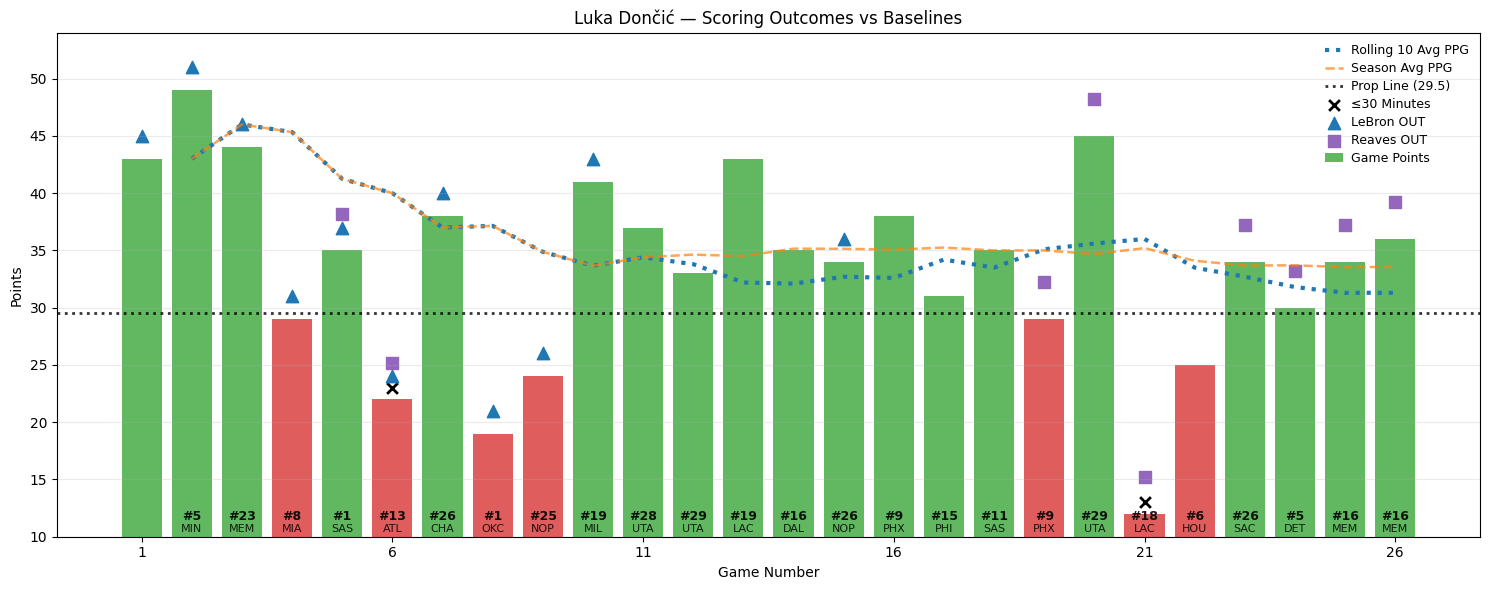

In [ ]:
# PLOTTING CELL 1


# =========================================================
# 1) Prepare Luka plotting dataframe
# =========================================================

plot_df = (
    luka
    .sort_values(["game_date", "game_id"])
    .reset_index(drop=True)
)

plot_df["game_number"] = np.arange(1, len(plot_df) + 1)
x = np.arange(len(plot_df))

plot_df["game_date_dt"] = pd.to_datetime(plot_df["game_date"])

# =========================================================
# 2) Build opponent lookup from TEAM box scores
# =========================================================

opp_lookup = (
    tbs[["GAME_ID", "TEAM_ABBREVIATION"]]
    .rename(columns={
        "GAME_ID": "game_id",
        "TEAM_ABBREVIATION": "team"
    })
)

opp_lookup = (
    opp_lookup
    .merge(
        opp_lookup,
        on="game_id",
        suffixes=("", "_opp")
    )
    .query("team != team_opp")
    [["game_id", "team", "team_opp"]]
    .drop_duplicates()
    .rename(columns={"team_opp": "OPP_TEAM"})
)

# Luka team = LAL
plot_df = plot_df.merge(
    opp_lookup[opp_lookup["team"] == "LAL"][["game_id", "OPP_TEAM"]],
    on="game_id",
    how="left",
    validate="one_to_one"
)

# =========================================================
# 3) AS-OF MERGE opponent defensive rank
# =========================================================

team_defense_daily = team_defense_daily.copy()
team_defense_daily["as_of_date"] = pd.to_datetime(team_defense_daily["as_of_date"])

team_defense_daily = team_defense_daily.rename(
    columns={"TEAM_ABBREVIATION": "OPP_TEAM"}
)

plot_df = plot_df.sort_values("game_date_dt")
team_defense_daily = team_defense_daily.sort_values("as_of_date")

plot_df = pd.merge_asof(
    plot_df,
    team_defense_daily,
    left_on="game_date_dt",
    right_on="as_of_date",
    by="OPP_TEAM",
    direction="backward"
)

plot_df = plot_df.rename(columns={"def_rank": "opp_def_rank"})

# =========================================================
# 4) Bar colors (prop logic)
# =========================================================

bar_colors = np.where(
    plot_df["points"] >= 30,
    "tab:green",
    "tab:red"
)

# =========================================================
# 5) Plot
# =========================================================

fig, ax = plt.subplots(figsize=(15, 6))

ax.bar(
    x,
    plot_df["points"],
    color=bar_colors,
    alpha=0.75,
    label="Game Points"
)

ax.plot(
    x,
    plot_df["r10_avg_ppg"],
    linestyle=":",
    linewidth=3,
    label="Rolling 10 Avg PPG"
)

ax.plot(
    x,
    plot_df["szn_avg_ppg"],
    linestyle="--",
    linewidth=1.8,
    alpha=0.7,
    label="Season Avg PPG"
)

ax.axhline(
    29.5,
    linestyle=":",
    linewidth=2,
    color="black",
    alpha=0.8,
    label="Prop Line (29.5)"
)

# =========================================================
# 6) Low minutes marker (≤30)
# =========================================================

def minutes_to_float(min_str):
    if pd.isna(min_str):
        return np.nan
    m, s = min_str.split(":")
    return int(m) + int(s) / 60

plot_df["minutes_float"] = plot_df["minutes"].apply(minutes_to_float)
low_min_mask = plot_df["minutes_float"] <= 30

ax.scatter(
    x[low_min_mask],
    plot_df.loc[low_min_mask, "points"] + 1,
    marker="x",
    color="black",
    s=60,
    linewidths=2,
    label="≤30 Minutes"
)

# =========================================================
# 7) Teammate absence markers
# =========================================================

pbs_names = pbs.copy()
pbs_names["familyName"] = pbs_names["familyName"].str.lower()

luka_game_ids = set(plot_df["game_id"])

reaves_games = set(
    pbs_names[
        (pbs_names["familyName"] == "reaves") &
        (pbs_names["game_id"].isin(luka_game_ids))
    ]["game_id"]
)

lebron_games = set(
    pbs_names[
        (pbs_names["personId"] == 2544) &
        (pbs_names["game_id"].isin(luka_game_ids))
    ]["game_id"]
)

plot_df["reaves_out"] = ~plot_df["game_id"].isin(reaves_games)
plot_df["lebron_out"] = ~plot_df["game_id"].isin(lebron_games)

ax.scatter(
    x[plot_df["lebron_out"]],
    plot_df.loc[plot_df["lebron_out"], "points"] + 2.0,
    marker="^",
    color="tab:blue",
    s=80,
    label="LeBron OUT"
)

ax.scatter(
    x[plot_df["reaves_out"]],
    plot_df.loc[plot_df["reaves_out"], "points"] + 3.2,
    marker="s",
    color="tab:purple",
    s=70,
    label="Reaves OUT"
)

# =========================================================
# 8) Opponent team + defensive rank labels (BOTTOM)
# =========================================================

for i, row in plot_df.iterrows():
    if not pd.isna(row["opp_def_rank"]):
        ax.text(
            i,
            10.2,
            f'{row["OPP_TEAM"]}',
            ha="center",
            va="bottom",
            fontsize=8,
            alpha=0.85
        )
        ax.text(
            i,
            11.2,
            f'#{int(row["opp_def_rank"])}',
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
            alpha=0.9
        )

# Plot FGA bars

# ax.bar(
#     x,
#     plot_df["fieldGoalsAttempted"],
#     color="black",
#     alpha=0.4,
#     width=0.35,
#     label="Game FGA"
# )

# =========================================================
# 9) Formatting
# =========================================================

ax.set_ylim(10, plot_df["points"].max() + 5)
ax.set_ylabel("Points")
ax.set_xlabel("Game Number")
ax.set_title("Luka Dončić — Scoring Outcomes vs Baselines")

ax.set_xticks(x[::5])
ax.set_xticklabels(plot_df["game_number"][::5])

ax.grid(axis="y", alpha=0.25)
ax.legend(
    fontsize=9,
    frameon=False,
    labelspacing=0.4,
    handlelength=1.5,
    handletextpad=0.6
)

plt.tight_layout()
plt.show()


In [95]:
import pandas as pd

# ---------------------------------------------------------
# 1) Base table: ALL games in the season
# ---------------------------------------------------------

season_games = (
    pbs[["game_id", "game_date", "teamId"]]
    .drop_duplicates()
    .sort_values("game_date")
    .reset_index(drop=True)
)

lal_games = season_games[season_games["teamId"] == 1610612747]

# ---------------------------------------------------------
# 2) Normalize names once
# ---------------------------------------------------------

pbs_check = pbs.copy()
pbs_check["familyName"] = pbs_check["familyName"].str.lower()
pbs_check["firstName"] = pbs_check["firstName"].str.lower()

# ---------------------------------------------------------
# 3) Player appearance tables
# ---------------------------------------------------------

# Luka (personId is safest)
luka_games = (
    pbs_check[pbs_check["personId"] == 1629029]  # Luka Dončić
    [["game_id"]]
    .drop_duplicates()
    .assign(luka_played=True)
)

# LeBron
lebron_games = (
    pbs_check[pbs_check["personId"] == 2544]  # LeBron James
    [["game_id"]]
    .drop_duplicates()
    .assign(lebron_played=True)
)

# Austin Reaves
reaves_games = (
    pbs_check[
        (pbs_check["familyName"] == "reaves") &
        (pbs_check["firstName"] == "austin")
    ][["game_id"]]
    .drop_duplicates()
    .assign(reaves_played=True)
)

# ---------------------------------------------------------
# 4) Left join everything onto season games
# ---------------------------------------------------------

validation = (
    lal_games
    .merge(luka_games, on="game_id", how="left")
    .merge(lebron_games, on="game_id", how="left")
    .merge(reaves_games, on="game_id", how="left")
)

# Fill NaNs → False (did not play)
for col in ["luka_played", "lebron_played", "reaves_played"]:
    validation[col] = validation[col].fillna(False)

# Optional OUT flags (nice for plotting)
validation["luka_out"] = ~validation["luka_played"]
validation["lebron_out"] = ~validation["lebron_played"]
validation["reaves_out"] = ~validation["reaves_played"]

# Add game number for readability
validation["game_number"] = validation.index + 1

# ---------------------------------------------------------
# 5) Summary sanity check
# ---------------------------------------------------------

summary = pd.DataFrame({
    "Player": ["Luka", "LeBron", "Reaves"],
    "Games Played": [
        validation["luka_played"].sum(),
        validation["lebron_played"].sum(),
        validation["reaves_played"].sum()
    ],
    "Games Missed": [
        validation["luka_out"].sum(),
        validation["lebron_out"].sum(),
        validation["reaves_out"].sum()
    ]
})

print("SEASON SUMMARY")
display(summary)

# ---------------------------------------------------------
# 6) Full truth table (authoritative)
# ---------------------------------------------------------

display(
    validation[
        ["game_number", "game_date", "game_id",
         "luka_played", "lebron_played", "reaves_played"]
    ]
)


SEASON SUMMARY


/var/folders/zb/kdjvw_5d73q1b2mg3fkcy8pw0000gn/T/ipykernel_39276/2664611340.py:67: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation[col] = validation[col].fillna(False)


,Player,Games Played,Games Missed
0,Luka,26,7
1,LeBron,17,16
2,Reaves,23,10


,game_number,game_date,game_id,luka_played,lebron_played,reaves_played
0,1,2025-10-21,22500002,True,False,True
1,2,2025-10-24,22500019,True,False,True
2,3,2025-10-26,22500113,False,False,True
3,4,2025-10-27,22500122,False,False,True
4,5,2025-10-29,22500136,False,False,True
5,6,2025-10-31,22500024,True,False,True
6,7,2025-11-02,22500155,True,False,True
7,8,2025-11-03,22500163,False,False,False
8,9,2025-11-05,22500179,True,False,False
9,10,2025-11-08,22500185,True,False,False


# Reorganizing DataFrames

In [127]:
# Load in player data
pbs = pd.read_csv("player_boxscores_2025_26.csv")

# Convert game_date to datetime type
pbs["game_date"] = pd.to_datetime(pbs["game_date"])

# Convert minutes to float 
def minutes_to_float(min_str):
    if pd.isna(min_str):
        return None
    m, s = min_str.split(":")
    return int(m) + int(s) / 60

pbs["minutes"] = pbs["minutes"].apply(minutes_to_float)

# Compute season and rolling 10-game point averages
pbs["szn_avg_ppg"] = (
    pbs
    .groupby("personId")["points"]
    .transform(lambda s: s.shift(1).expanding().mean())
)

pbs["r10_avg_ppg"] = (
    pbs
    .groupby("personId")["points"]
    .transform(lambda s: s.shift(1).rolling(10, min_periods=1).mean())
)

p = pbs[["gameId", "teamTricode", "firstName", "familyName", "points"]]

p.head()

/var/folders/zb/kdjvw_5d73q1b2mg3fkcy8pw0000gn/T/ipykernel_39276/986353756.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pbs["game_date"] = pd.to_datetime(pbs["game_date"])


,gameId,teamTricode,firstName,familyName,points
0,22500463,ATL,Zaccharie,Risacher,9
1,22500463,ATL,Jalen,Johnson,34
2,22500463,ATL,Onyeka,Okongwu,17
3,22500463,ATL,Dyson,Daniels,11
4,22500463,ATL,Nickeil,Alexander-Walker,11


In [145]:
# Load in team data
tbs = pd.read_csv("league_gamelog_2025_26.csv")

tbs["GAME_DATE"] = pd.to_datetime(tbs["GAME_DATE"])

opp = (
    tbs[["GAME_ID", "TEAM_ABBREVIATION", "PTS"]]
    .rename(columns={
        "TEAM_ABBREVIATION": "OPP_TEAM",
        "PTS": "OPP_PTS"
    })
)

merged = tbs.merge(
    opp,
    on="GAME_ID",
    how="left",
    validate="many_to_many"
)

merged = merged[merged["TEAM_ABBREVIATION"] != merged["OPP_TEAM"]]

tbs = (
    merged
    .rename(columns={"OPP_PTS": "PTS_ALLOWED"})
    .drop(columns="OPP_TEAM")
)

t = tbs[["GAME_ID", "TEAM_ABBREVIATION", "GAME_DATE", "PTS", "MATCHUP", "PTS_ALLOWED", "WL"]]

t.tail()

,GAME_ID,TEAM_ABBREVIATION,GAME_DATE,PTS,MATCHUP,PTS_ALLOWED,WL
2130,22500507,DEN,2026-01-05,125,DEN @ PHI,124,W
2133,22500509,POR,2026-01-05,137,POR vs. UTA,117,W
2134,22500509,UTA,2026-01-05,117,UTA @ POR,137,L
2137,22500508,LAC,2026-01-05,103,LAC vs. GSW,102,W
2138,22500508,GSW,2026-01-05,102,GSW @ LAC,103,L


In [150]:
# Get all unique game dates in order
season_start = tbs["GAME_DATE"].min()
season_end = tbs["GAME_DATE"].max() + pd.Timedelta(days=1)

game_dates = pd.date_range(
    start=season_start,
    end=season_end,
    freq="D"
)

daily_ranks = []

for game_date in game_dates:
    prior_games = tbs[tbs["GAME_DATE"] < game_date]

    # Skip dates before anyone has played
    if prior_games.empty:
        continue

    ranks = (
        prior_games
        .groupby("TEAM_ABBREVIATION", as_index=False)
        .agg(
            games_played=("GAME_ID", "count"),
            avg_pts=("PTS", "mean"),
            avg_pts_allowed=("PTS_ALLOWED", "mean"),
        )
    )

    # Ranks (league context as of this date)
    ranks["off_rank"] = ranks["avg_pts"].rank(
        method="first", ascending=False
    )
    ranks["def_rank"] = ranks["avg_pts_allowed"].rank(
        method="first", ascending=True
    )

    ranks["game_date"] = game_date
    daily_ranks.append(ranks)

daily_ranks = (
    pd.concat(daily_ranks, ignore_index=True)
    .sort_values(["game_date", "def_rank"])
)

daily_ranks.tail(30)


,TEAM_ABBREVIATION,games_played,avg_pts,avg_pts_allowed,off_rank,def_rank,game_date
2272,OKC,37,121.243243,107.621622,2.0,1.0,2026-01-06
2254,BOS,35,117.771429,110.457143,13.0,2.0,2026-01-06
2262,HOU,33,119.393939,110.969697,8.0,3.0,2026-01-06
2260,DET,36,118.833333,112.111111,10.0,4.0,2026-01-06
2279,TOR,37,114.486486,112.297297,23.0,5.0,2026-01-06
2275,PHX,36,114.750000,112.805556,22.0,6.0,2026-01-06
2261,GSW,37,114.837838,113.648649,21.0,7.0,2026-01-06
2278,SAS,35,119.742857,114.171429,4.0,8.0,2026-01-06
2264,LAC,35,112.114286,114.200000,27.0,9.0,2026-01-06
2253,BKN,33,109.454545,114.272727,30.0,10.0,2026-01-06


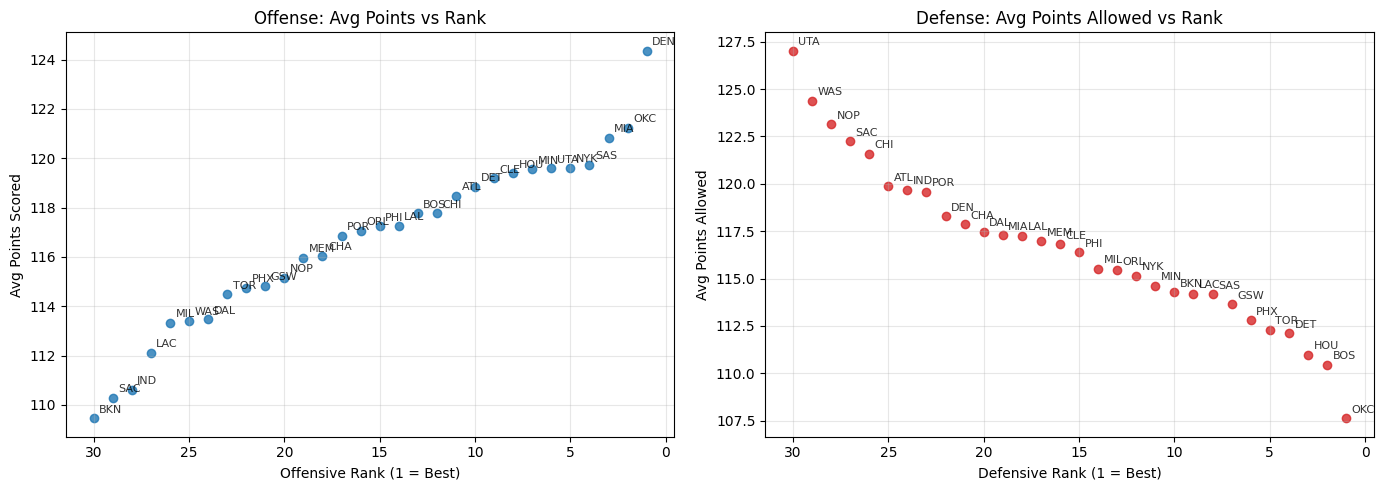

In [149]:
import matplotlib.pyplot as plt

# Use the latest snapshot (e.g., 2026-01-06)
latest_date = daily_ranks["game_date"].max()

df = (
    daily_ranks[daily_ranks["game_date"] == latest_date]
    .sort_values("TEAM_ABBREVIATION")
)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

# =========================================================
# 1) Offensive: Avg PTS vs Offensive Rank
# =========================================================
axes[0].scatter(
    df["off_rank"],
    df["avg_pts"],
    alpha=0.8
)

axes[0].invert_xaxis()  # rank 1 on the left
axes[0].set_title("Offense: Avg Points vs Rank")
axes[0].set_xlabel("Offensive Rank (1 = Best)")
axes[0].set_ylabel("Avg Points Scored")

# Annotate teams (optional but very useful)
for _, row in df.iterrows():
    axes[0].annotate(
        row["TEAM_ABBREVIATION"],
        (row["off_rank"], row["avg_pts"]),
        textcoords="offset points",
        xytext=(4, 4),
        fontsize=8,
        alpha=0.8
    )

axes[0].grid(alpha=0.3)


# =========================================================
# 2) Defensive: Avg PTS Allowed vs Defensive Rank
# =========================================================
axes[1].scatter(
    df["def_rank"],
    df["avg_pts_allowed"],
    alpha=0.8,
    color="tab:red"
)

axes[1].invert_xaxis()  # rank 1 on the left
axes[1].set_title("Defense: Avg Points Allowed vs Rank")
axes[1].set_xlabel("Defensive Rank (1 = Best)")
axes[1].set_ylabel("Avg Points Allowed")

for _, row in df.iterrows():
    axes[1].annotate(
        row["TEAM_ABBREVIATION"],
        (row["def_rank"], row["avg_pts_allowed"]),
        textcoords="offset points",
        xytext=(4, 4),
        fontsize=8,
        alpha=0.8
    )

axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


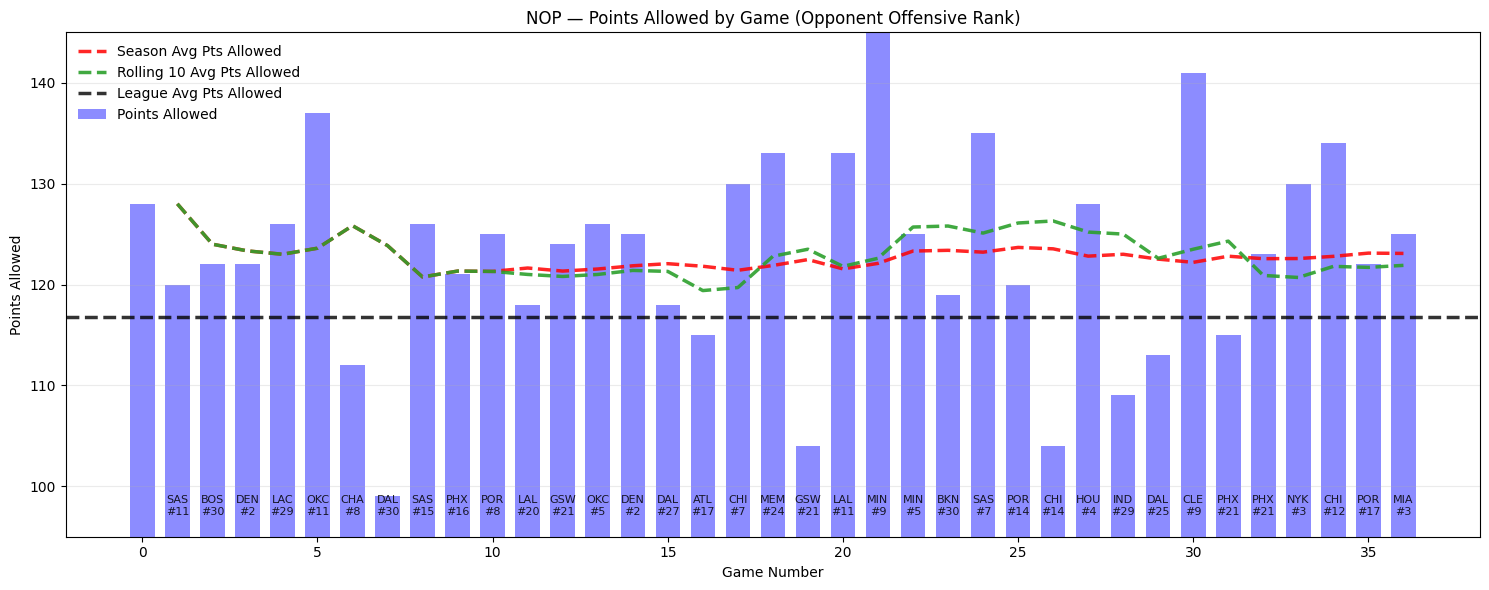

In [ ]:
# PLOTTING OPP DEFENSE - POINTS ALLOWED PER GAME

# =========================================================
# 1) Prep team box scores
# =========================================================

tbs_plot = tbs.copy()
tbs_plot["GAME_DATE_DT"] = pd.to_datetime(tbs_plot["GAME_DATE"])

nop_games = (
    tbs_plot[tbs_plot["TEAM_ABBREVIATION"] == "NOP"]
    .sort_values("GAME_DATE_DT")
    .reset_index(drop=True)
)

# Opponent abbreviation
nop_games["OPP_TEAM"] = nop_games["MATCHUP"].str[-3:]

# =========================================================
# 2) Season-to-date avg points allowed (NO leakage)
# =========================================================

nop_games["szn_avg_pts_allowed"] = (
    nop_games["PTS_ALLOWED"]
    .shift(1)                    # only prior games
    .expanding()
    .mean()
)

# Rolling 10-game avg points allowed (prior games only)
nop_games["r10_avg_pts_allowed"] = (
    nop_games["PTS_ALLOWED"]
    .shift(1)
    .rolling(10, min_periods=1)
    .mean()
)

# League-wide avg points allowed
league_avg_pts_allowed = (
    tbs[tbs["GAME_DATE"] <= nop_games["GAME_DATE"].max()]
    ["PTS_ALLOWED"]
    .mean()
)

# =========================================================
# 3) Attach opponent OFFENSIVE rank (as of game date)
# =========================================================

daily_ranks_plot = daily_ranks.copy()
daily_ranks_plot["game_date_dt"] = pd.to_datetime(daily_ranks_plot["game_date"])

nop_games = nop_games.sort_values("GAME_DATE_DT")
daily_ranks_plot = daily_ranks_plot.sort_values("game_date_dt")

nop_games = pd.merge_asof(
    nop_games,
    daily_ranks_plot,
    left_on="GAME_DATE_DT",
    right_on="game_date_dt",
    left_by="OPP_TEAM",
    right_by="TEAM_ABBREVIATION",
    direction="backward"
)

# =========================================================
# 4) Plot
# =========================================================

x = np.arange(len(nop_games))

fig, ax = plt.subplots(figsize=(15, 6))

# -----------------------------
# Bars: points allowed
# -----------------------------
ax.bar(
    x,
    nop_games["PTS_ALLOWED"],
    width=0.7,
    color="blue",
    alpha=0.45,
    label="Points Allowed"
)


# -----------------------------
# Season avg line
# -----------------------------
ax.plot(
    x,
    nop_games["szn_avg_pts_allowed"],
    linestyle="--",
    linewidth=2.5,
    color="red",
    alpha=0.85,
    label="Season Avg Pts Allowed"
)


# Rolling 10 avg line
ax.plot(
    x,
    nop_games["r10_avg_pts_allowed"],
    linestyle="--",
    linewidth=2.5,
    color="tab:green",
    alpha=0.9,
    label="Rolling 10 Avg Pts Allowed"
)

# League-wide avg line
ax.axhline(
    league_avg_pts_allowed,
    linestyle="--",
    linewidth=2.5,
    color="black",
    alpha=0.8,
    label="League Avg Pts Allowed"
)

# -----------------------------
# Bottom labels: opponent + off rank
# -----------------------------
for i, row in nop_games.iterrows():
    if pd.notna(row["off_rank"]):
        ax.text(
            i,
            97,
            f'{row["OPP_TEAM"]}\n#{int(row["off_rank"])}',
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.85
        )

# -----------------------------
# Formatting
# -----------------------------
ax.set_title("NOP — Points Allowed by Game (Opponent Offensive Rank)")
ax.set_ylabel("Points Allowed")
ax.set_xlabel("Game Number")

# ax.set_ylim(80, nop_games["PTS_ALLOWED"].max() + 5)
ax.set_ylim(95, 145)

# ax.set_xticks(x[::5])
# ax.set_xticklabels(x[::5] + 1)

ax.grid(axis="y", alpha=0.25)
ax.legend(
    loc="upper left",
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()


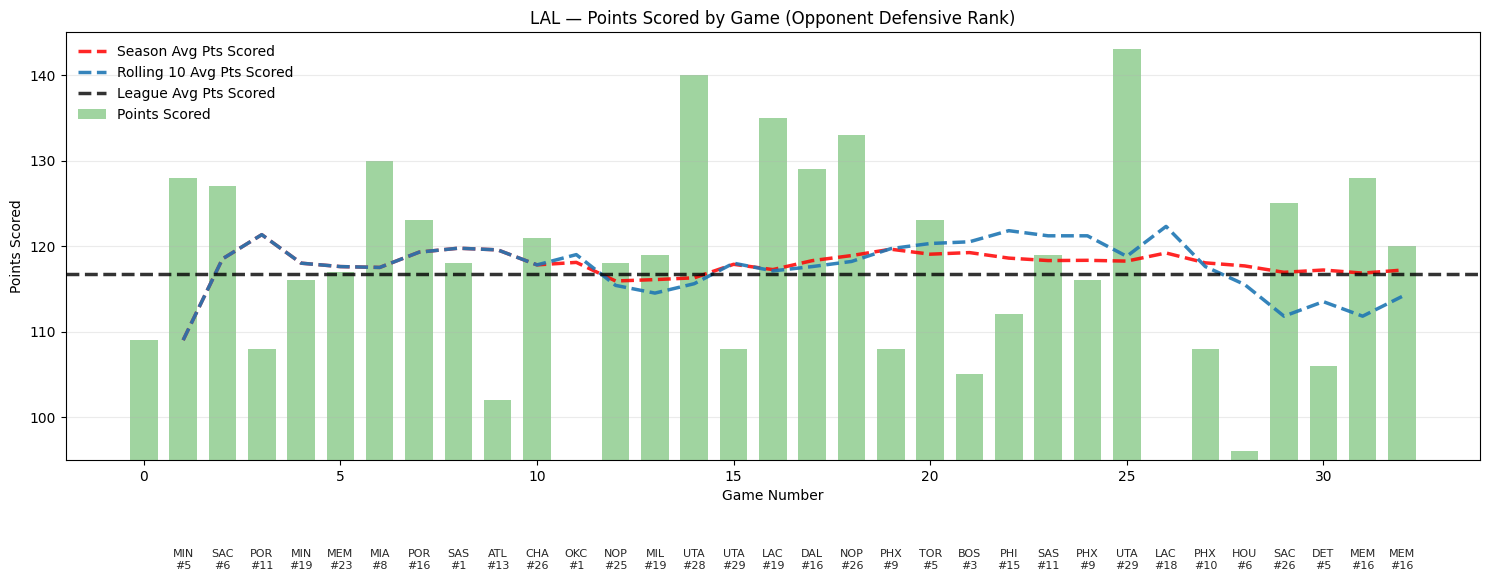

In [ ]:
# =========================================================
# 1) Prep team box scores
# =========================================================

tbs_plot = tbs.copy()
tbs_plot["GAME_DATE_DT"] = pd.to_datetime(tbs_plot["GAME_DATE"])

lal_games = (
    tbs_plot[tbs_plot["TEAM_ABBREVIATION"] == "LAL"]
    .sort_values("GAME_DATE_DT")
    .reset_index(drop=True)
)

# Opponent abbreviation
lal_games["OPP_TEAM"] = lal_games["MATCHUP"].str[-3:]

# =========================================================
# 2) Season-to-date avg points scored (NO leakage)
# =========================================================

lal_games["szn_avg_pts_scored"] = (
    lal_games["PTS"]
    .shift(1)
    .expanding()
    .mean()
)

# Rolling 10-game avg points scored (prior games only)
lal_games["r10_avg_pts_scored"] = (
    lal_games["PTS"]
    .shift(1)
    .rolling(10, min_periods=1)
    .mean()
)

# League-wide avg team points scored (as-of cutoff)
league_avg_pts_scored = (
    tbs[tbs["GAME_DATE"] <= lal_games["GAME_DATE"].max()]
    ["PTS"]
    .mean()
)

# =========================================================
# 3) Attach opponent DEFENSIVE rank (as of game date)
# =========================================================

daily_ranks_plot = daily_ranks.copy()
daily_ranks_plot["game_date_dt"] = pd.to_datetime(daily_ranks_plot["game_date"])

lal_games = lal_games.sort_values("GAME_DATE_DT")
daily_ranks_plot = daily_ranks_plot.sort_values("game_date_dt")

lal_games = pd.merge_asof(
    lal_games,
    daily_ranks_plot,
    left_on="GAME_DATE_DT",
    right_on="game_date_dt",
    left_by="OPP_TEAM",
    right_by="TEAM_ABBREVIATION",
    direction="backward"
)

# =========================================================
# 4) Plot
# =========================================================

x = np.arange(len(lal_games))

fig, ax = plt.subplots(figsize=(15, 6))

# -----------------------------
# Bars: points scored
# -----------------------------
ax.bar(
    x,
    lal_games["PTS"],
    width=0.7,
    color="tab:green",
    alpha=0.45,
    label="Points Scored"
)

# -----------------------------
# Season avg line
# -----------------------------
ax.plot(
    x,
    lal_games["szn_avg_pts_scored"],
    linestyle="--",
    linewidth=2.5,
    color="red",
    alpha=0.85,
    label="Season Avg Pts Scored"
)

# Rolling 10 avg line
ax.plot(
    x,
    lal_games["r10_avg_pts_scored"],
    linestyle="--",
    linewidth=2.5,
    color="tab:blue",
    alpha=0.9,
    label="Rolling 10 Avg Pts Scored"
)

# League-wide avg line
ax.axhline(
    league_avg_pts_scored,
    linestyle="--",
    linewidth=2.5,
    color="black",
    alpha=0.8,
    label="League Avg Pts Scored"
)

# -----------------------------
# Bottom labels: opponent + DEF rank
# -----------------------------
for i, row in lal_games.iterrows():
    if pd.notna(row["def_rank"]):
        ax.text(
            i,
            lal_games["PTS"].min() - 6,
            f'{row["OPP_TEAM"]}\n#{int(row["def_rank"])}',
            ha="center",
            va="bottom",
            fontsize=8,
            color="black",
            alpha=0.85
        )

# -----------------------------
# Formatting
# -----------------------------
ax.set_title("LAL — Points Scored by Game (Opponent Defensive Rank)")
ax.set_ylabel("Points Scored")
ax.set_xlabel("Game Number")

# ax.set_ylim(
#     lal_games["PTS"].min() - 10,
#     lal_games["PTS"].max() + 5
# )



ax.grid(axis="y", alpha=0.25)
ax.legend(
    loc="upper left",
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()


In [183]:
# =========================================================
# 1) Luka player-game stats
# =========================================================

luka_df = (
    pbs[pbs["personId"] == 1629029]  # Luka Dončić
    [["game_id", "game_date", "points", "minutes"]]
    .drop_duplicates()
)

# =========================================================
# 2) LAL team points for those games
# =========================================================

lal_team_pts = (
    tbs[tbs["TEAM_ABBREVIATION"] == "LAL"]
    [["GAME_ID", "GAME_DATE", "PTS", "MATCHUP"]]
    .rename(columns={
        "GAME_ID": "game_id",
        "GAME_DATE": "game_date",
        "PTS": "team_pts"
    })
)

# =========================================================
# 3) Merge Luka ↔ team context
# =========================================================

luka_plot_df = (
    luka_df
    .merge(lal_team_pts, on=["game_id", "game_date"], how="left", validate="one_to_one")
)

# =========================================================
# 4) Opponent team abbreviation
# =========================================================

luka_plot_df["OPP_TEAM"] = luka_plot_df["MATCHUP"].str[-3:]

# =========================================================
# 5) Add teammate availability (from validation table)
# =========================================================

luka_plot_df = (
    luka_plot_df
    .merge(
        validation[["game_id", "lebron_out", "reaves_out"]],
        on="game_id",
        how="left"
    )
)

# Safety fill
luka_plot_df[["lebron_out", "reaves_out"]] = (
    luka_plot_df[["lebron_out", "reaves_out"]].fillna(False)
)

# =========================================================
# 6) Final cleanup / ordering
# =========================================================

luka_plot_df["game_date"] = pd.to_datetime(luka_plot_df["game_date"])
luka_plot_df = (
    luka_plot_df
    .sort_values("game_date")
    .reset_index(drop=True)
)

luka_plot_df["game_number"] = luka_plot_df.index + 1

# =========================================================
# 7) Inspect
# =========================================================

display(
    luka_plot_df[
        ["game_number", "game_date", "points", "team_pts",
         "lebron_out", "reaves_out", "OPP_TEAM"]
    ]
)


,game_number,game_date,points,team_pts,lebron_out,reaves_out,OPP_TEAM
0,1,2025-10-21,43,109,True,False,GSW
1,2,2025-10-24,49,128,True,False,MIN
2,3,2025-10-31,44,117,True,False,MEM
3,4,2025-11-02,29,130,True,False,MIA
4,5,2025-11-05,35,118,True,True,SAS
5,6,2025-11-08,22,102,True,True,ATL
6,7,2025-11-10,38,121,True,False,CHA
7,8,2025-11-12,19,92,True,False,OKC
8,9,2025-11-14,24,118,True,False,NOP
9,10,2025-11-15,41,119,True,False,MIL


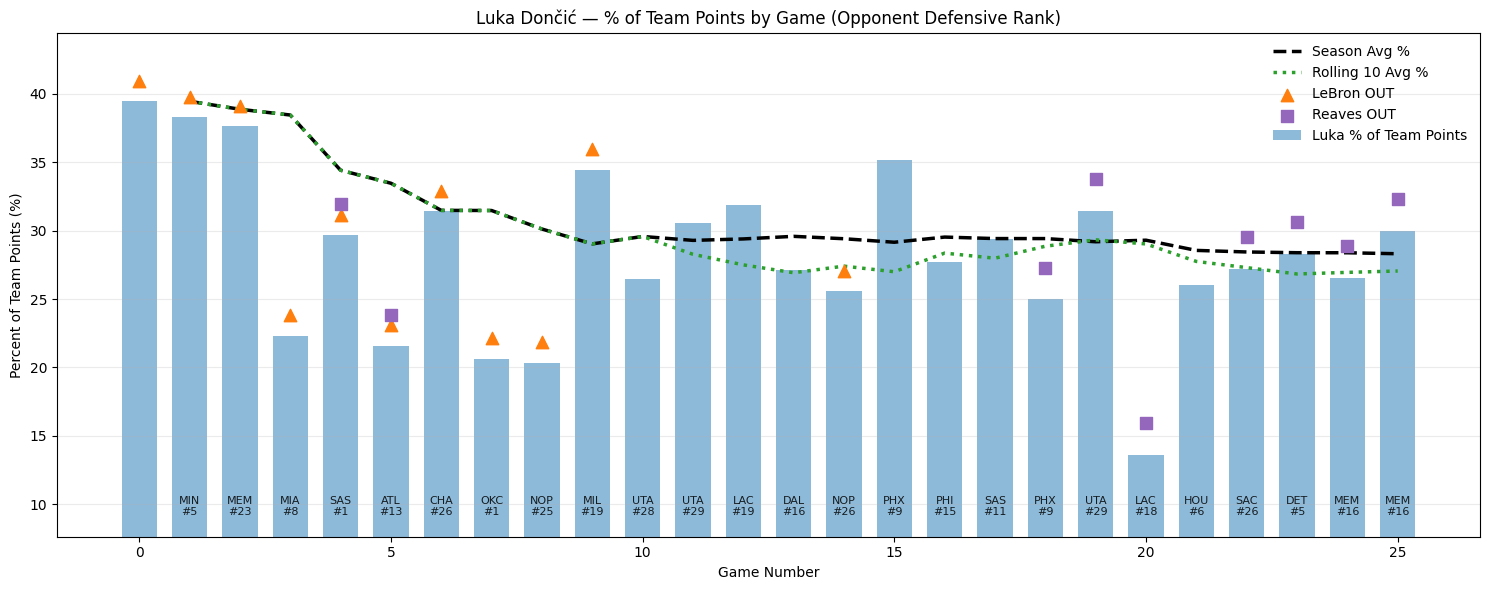

In [ ]:
# PLOTTING PLAYER PERCENTAGE OF TEAM POINTS

# =========================================================
# 1) Prep player + team data
# =========================================================

plot_df = luka_plot_df.copy()  # assumes one row per Luka game
plot_df["GAME_DATE_DT"] = pd.to_datetime(plot_df["game_date"])
plot_df = plot_df.sort_values("GAME_DATE_DT").reset_index(drop=True)

# Luka % of team points
plot_df["luka_pct_team_pts"] = plot_df["points"] / plot_df["team_pts"] * 100

# Season avg % (prior games only)
plot_df["szn_avg_luka_pct"] = (
    plot_df["luka_pct_team_pts"]
    .shift(1)
    .expanding()
    .mean()
)

# Rolling 10-game avg % (prior games only)
plot_df["r10_avg_luka_pct"] = (
    plot_df["luka_pct_team_pts"]
    .shift(1)
    .rolling(10, min_periods=1)
    .mean()
)

# =========================================================
# 2) Attach opponent defensive rank (as of game date)
# =========================================================

daily_ranks_plot = daily_ranks.copy()
daily_ranks_plot["game_date_dt"] = pd.to_datetime(daily_ranks_plot["game_date"])

plot_df = plot_df.sort_values("GAME_DATE_DT")
daily_ranks_plot = daily_ranks_plot.sort_values("game_date_dt")

plot_df = pd.merge_asof(
    plot_df,
    daily_ranks_plot,
    left_on="GAME_DATE_DT",
    right_on="game_date_dt",
    left_by="OPP_TEAM",
    right_by="TEAM_ABBREVIATION",
    direction="backward"
)

# =========================================================
# 3) Plot
# =========================================================

x = np.arange(len(plot_df))

fig, ax = plt.subplots(figsize=(15, 6))

# -----------------------------
# Bars: Luka % of team points
# -----------------------------
ax.bar(
    x,
    plot_df["luka_pct_team_pts"],
    width=0.7,
    color="tab:blue",
    alpha=0.5,
    label="Luka % of Team Points"
)

# -----------------------------
# Avg lines
# -----------------------------
ax.plot(
    x,
    plot_df["szn_avg_luka_pct"],
    linestyle="--",
    linewidth=2.5,
    color="black",
    label="Season Avg %"
)

ax.plot(
    x,
    plot_df["r10_avg_luka_pct"],
    linestyle=":",
    linewidth=2.5,
    color="tab:green",
    label="Rolling 10 Avg %"
)

# -----------------------------
# Injury markers
# -----------------------------
ax.scatter(
    plot_df.index[plot_df["lebron_out"]],
    plot_df.loc[plot_df["lebron_out"], "luka_pct_team_pts"] + 1.5,
    marker="^",
    s=80,
    color="tab:orange",
    label="LeBron OUT",
    zorder=5
)

ax.scatter(
    plot_df.index[plot_df["reaves_out"]],
    plot_df.loc[plot_df["reaves_out"], "luka_pct_team_pts"] + 2.3,
    marker="s",
    s=70,
    color="tab:purple",
    label="Reaves OUT",
    zorder=5
)

# -----------------------------
# Bottom labels: opponent + def rank
# -----------------------------
y_min = plot_df["luka_pct_team_pts"].min()

for i, row in plot_df.iterrows():
    if pd.notna(row["def_rank"]):
        ax.text(
            i,
            y_min - 3,
            f'{row["OPP_TEAM"]}\n#{int(row["def_rank"])}',
            ha="center",
            va="top",
            fontsize=8,
            alpha=0.85
        )

# -----------------------------
# Formatting
# -----------------------------
ax.set_title("Luka Dončić — % of Team Points by Game (Opponent Defensive Rank)")
ax.set_ylabel("Percent of Team Points (%)")
ax.set_xlabel("Game Number")

ax.set_ylim(y_min - 6, plot_df["luka_pct_team_pts"].max() + 5)

ax.grid(axis="y", alpha=0.25)

ax.legend(
    loc="upper right",
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()


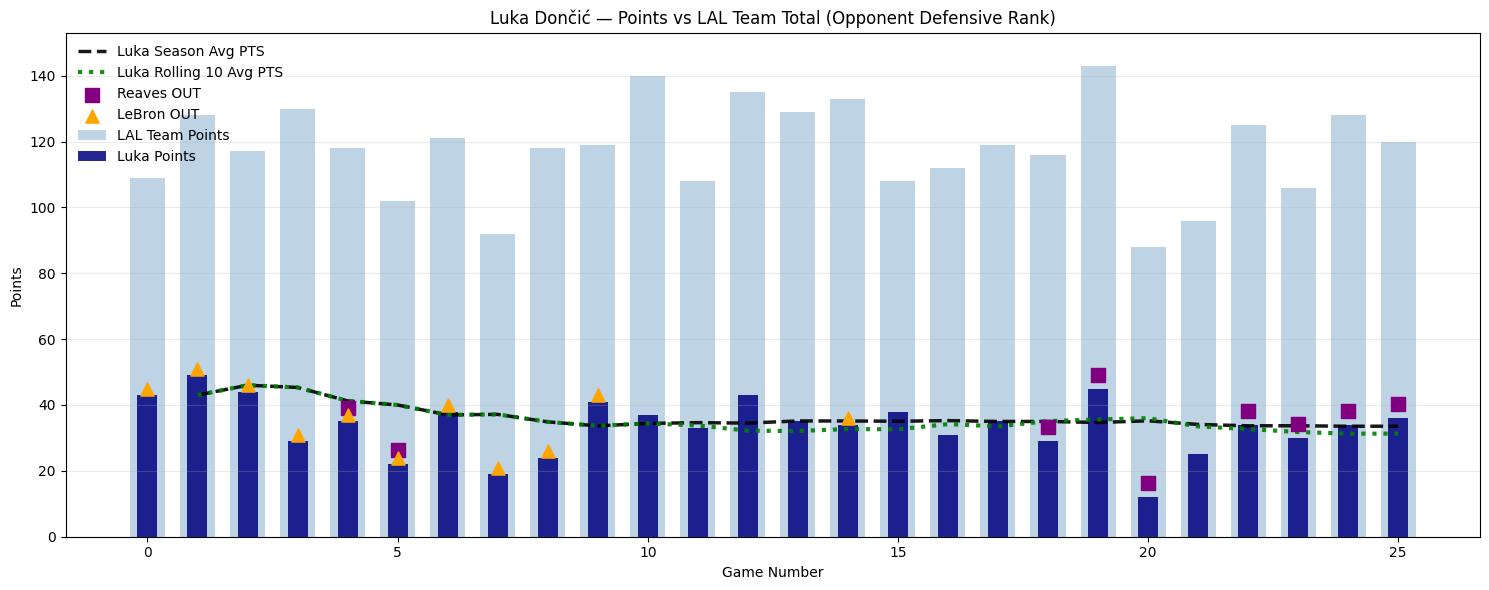

In [ ]:
# PLOTTING PLAYER / TEAM POINTS BAR OVERLAP

import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 1) Prep metrics
# =========================================================

df = luka_plot_df.copy()

# Luka season avg (no leakage)
df["szn_avg_luka_pts"] = (
    df["points"]
    .shift(1)
    .expanding()
    .mean()
)

# Luka rolling 10 avg (no leakage)
df["r10_avg_luka_pts"] = (
    df["points"]
    .shift(1)
    .rolling(10, min_periods=1)
    .mean()
)

x = np.arange(len(df))

# =========================================================
# 2) Plot
# =========================================================

fig, ax = plt.subplots(figsize=(15, 6))

# -----------------------------
# Bars: TEAM points (background)
# -----------------------------
ax.bar(
    x,
    df["team_pts"],
    width=0.7,
    color="steelblue",
    alpha=0.35,
    label="LAL Team Points"
)

# -----------------------------
# Bars: LUKA points (foreground)
# -----------------------------
ax.bar(
    x,
    df["points"],
    width=0.4,
    color="navy",
    alpha=0.85,
    label="Luka Points"
)

# -----------------------------
# Luka season avg line
# -----------------------------
ax.plot(
    x,
    df["szn_avg_luka_pts"],
    linestyle="--",
    linewidth=2.5,
    color="black",
    alpha=0.9,
    label="Luka Season Avg PTS"
)

# -----------------------------
# Luka rolling 10 avg line
# -----------------------------
ax.plot(
    x,
    df["r10_avg_luka_pts"],
    linestyle=":",
    linewidth=3,
    color="green",
    alpha=0.9,
    label="Luka Rolling 10 Avg PTS"
)

# =========================================================
# 3) Injury markers (same logic as before)
# =========================================================

# Reaves OUT
ax.scatter(
    x[df["reaves_out"]],
    df.loc[df["reaves_out"], "points"] + 4.2,
    marker="s",
    s=90,
    color="purple",
    label="Reaves OUT",
    zorder=5
)

# LeBron OUT
ax.scatter(
    x[df["lebron_out"]],
    df.loc[df["lebron_out"], "points"] + 2,
    marker="^",
    s=90,
    color="orange",
    label="LeBron OUT",
    zorder=5
)

# =========================================================
# 4) Bottom labels: opponent + DEF rank
# =========================================================

for i, row in df.iterrows():
    if pd.notna(row.get("def_rank")):
        ax.text(
            i,
            5,
            f'{row["OPP_TEAM"]}\n#{int(row["def_rank"])}',
            ha="center",
            va="bottom",
            fontsize=8,
            alpha=0.85
        )

# =========================================================
# 5) Formatting
# =========================================================

ax.set_title("Luka Dončić — Points vs LAL Team Total (Opponent Defensive Rank)")
ax.set_xlabel("Game Number")
ax.set_ylabel("Points")

ax.set_ylim(0, max(df["team_pts"].max(), df["points"].max()) + 10)

ax.grid(axis="y", alpha=0.25)

ax.legend(
    loc="upper left",
    frameon=False,
    fontsize=10
)

plt.tight_layout()
plt.show()

In [199]:
print(tbs.columns)
print(pbs.columns)
print(daily_ranks.columns)

Index(['SEASON_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'GAME_ID',
       'GAME_DATE', 'MATCHUP', 'WL', 'MIN', 'FGM', 'FGA', 'FG_PCT', 'FG3M',
       'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PLUS_MINUS', 'VIDEO_AVAILABLE',
       'PTS_ALLOWED'],
      dtype='object')
Index(['gameId', 'teamId', 'teamCity', 'teamName', 'teamTricode', 'teamSlug',
       'personId', 'firstName', 'familyName', 'nameI', 'playerSlug',
       'position', 'comment', 'jerseyNum', 'minutes', 'fieldGoalsMade',
       'fieldGoalsAttempted', 'fieldGoalsPercentage', 'threePointersMade',
       'threePointersAttempted', 'threePointersPercentage', 'freeThrowsMade',
       'freeThrowsAttempted', 'freeThrowsPercentage', 'reboundsOffensive',
       'reboundsDefensive', 'reboundsTotal', 'assists', 'steals', 'blocks',
       'turnovers', 'foulsPersonal', 'points', 'plusMinusPoints', 'game_id',
       'game_date', 'szn_avg_ppg', 'r10_avg_ppg']

In [203]:
import pandas as pd

# =========================================================
# 1) Base: Luka game-level dataframe
# =========================================================

# Luka player games
luka_df = (
    pbs[pbs["personId"] == 1629029]   # Luka Dončić
    .copy()
)

luka_df["game_date_dt"] = pd.to_datetime(luka_df["game_date"])

# =========================================================
# 2) Merge TEAM context (WL, team points, opponent)
# =========================================================

tbs_ctx = tbs.copy()
tbs_ctx["GAME_DATE_DT"] = pd.to_datetime(tbs_ctx["GAME_DATE"])

# Lakers rows only
lal_games = tbs_ctx[tbs_ctx["TEAM_ABBREVIATION"] == "LAL"][
    ["GAME_ID", "GAME_DATE_DT", "WL", "PTS", "MATCHUP"]
].rename(columns={
    "PTS": "team_pts"
})

luka_df = luka_df.merge(
    lal_games,
    left_on="game_id",
    right_on="GAME_ID",
    how="left"
)

# Home / Away
luka_df["HOME_AWAY"] = luka_df["MATCHUP"].apply(
    lambda x: "AWAY" if "@" in x else "HOME"
)

# =========================================================
# 3) Merge opponent defensive rank (NO leakage)
# =========================================================

daily_ranks_plot = daily_ranks.copy()
daily_ranks_plot["game_date_dt"] = pd.to_datetime(daily_ranks_plot["game_date"])

# Opponent abbreviation
luka_df["OPP_TEAM"] = luka_df["MATCHUP"].str[-3:]

luka_df = luka_df.sort_values("game_date_dt")
daily_ranks_plot = daily_ranks_plot.sort_values("game_date_dt")

luka_df = pd.merge_asof(
    luka_df,
    daily_ranks_plot,
    left_on="game_date_dt",
    right_on="game_date_dt",
    left_by="OPP_TEAM",
    right_by="TEAM_ABBREVIATION",
    direction="backward"
)

# =========================================================
# 4) Teammate OUT flags (from earlier validated table)
# =========================================================

# Assumes you already built this table earlier
# validation has: game_id, lebron_out, reaves_out
luka_df = luka_df.merge(
    validation[["game_id", "lebron_out", "reaves_out"]],
    on="game_id",
    how="left"
)

luka_df[["lebron_out", "reaves_out"]] = luka_df[
    ["lebron_out", "reaves_out"]
].fillna(False)

# =========================================================
# 5) Hit flag + defense buckets
# =========================================================

prop_line = 29.5
luka_df["hit"] = luka_df["points"] > prop_line

def def_bucket(rank):
    if rank <= 10:
        return "Top 10 Defense"
    elif rank <= 20:
        return "Middle 10 Defense"
    else:
        return "Bottom 10 Defense"

luka_df["def_bucket"] = luka_df["def_rank"].apply(def_bucket)

# =========================================================
# 6) Helper for hit-rate rows
# =========================================================

def hit_row(df, label):
    return {
        "Category": label,
        "Games": len(df),
        "Hit Rate (%)": round(df["hit"].mean() * 100, 1)
    }

rows = []

# =========================================================
# 7) Build summary table
# =========================================================

rows.append(hit_row(luka_df, "Season (All Games)"))
rows.append(hit_row(luka_df.tail(10), "Last 10 Games"))

rows.append(hit_row(luka_df[luka_df["WL"] == "W"], "Wins"))
rows.append(hit_row(luka_df[luka_df["WL"] == "L"], "Losses"))

rows.append(hit_row(luka_df[luka_df["HOME_AWAY"] == "HOME"], "Home"))
rows.append(hit_row(luka_df[luka_df["HOME_AWAY"] == "AWAY"], "Away"))

rows.append(hit_row(luka_df[luka_df["lebron_out"]], "LeBron OUT"))
rows.append(hit_row(luka_df[luka_df["reaves_out"]], "Reaves OUT"))

rows.append(hit_row(
    luka_df[luka_df["lebron_out"] & luka_df["reaves_out"]],
    "LeBron + Reaves OUT"
))

rows.append(hit_row(
    luka_df[luka_df["def_bucket"] == "Top 10 Defense"],
    "Top 10 Defense"
))
rows.append(hit_row(
    luka_df[luka_df["def_bucket"] == "Middle 10 Defense"],
    "Middle 10 Defense"
))
rows.append(hit_row(
    luka_df[luka_df["def_bucket"] == "Bottom 10 Defense"],
    "Bottom 10 Defense"
))

summary_table = pd.DataFrame(rows)

display(summary_table)


,Category,Games,Hit Rate (%)
0,Season (All Games),26,73.1
1,Last 10 Games,10,70.0
2,Wins,18,83.3
3,Losses,8,50.0
4,Home,15,86.7
5,Away,11,54.5
6,LeBron OUT,11,63.6
7,Reaves OUT,9,66.7
8,LeBron + Reaves OUT,2,50.0
9,Top 10 Defense,8,50.0


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def load_process_pbs():
    # Load in player data
    pbs = pd.read_csv("player_boxscores_2025_26.csv")

    # Convert game_date to datetime type
    pbs["game_date"] = pd.to_datetime(pbs["game_date"])

    # Convert minutes to float 
    def minutes_to_float(min_str):
        if pd.isna(min_str):
            return None
        m, s = min_str.split(":")
        return int(m) + int(s) / 60

    pbs["minutes"] = pbs["minutes"].apply(minutes_to_float)

    # Sort for correct window behavior before calculating averages
    pbs = (
        pbs
        .sort_values(["personId", "game_date"])
        .reset_index(drop=True)
    )

    # Compute season and rolling 10-game point averages
    pbs["szn_avg_ppg"] = (
        pbs
        .groupby("personId")["points"]
        .transform(lambda s: s.shift(1).expanding().mean())
    )

    pbs["r10_avg_ppg"] = (
        pbs
        .groupby("personId")["points"]
        .transform(lambda s: s.shift(1).rolling(10, min_periods=1).mean())
    )

    # pbs = pbs[["gameId", "game_date", "teamTricode", "personId", "firstName", "familyName", "points", "szn_avg_ppg", "r10_avg_ppg"]]

    return pbs

def load_process_tbs():
    # Load in team data
    tbs = pd.read_csv("league_gamelog_2025_26.csv")

    tbs["GAME_DATE"] = pd.to_datetime(tbs["GAME_DATE"])

    opp = (
        tbs[["GAME_ID", "TEAM_ABBREVIATION", "PTS"]]
        .rename(columns={
            "TEAM_ABBREVIATION": "OPP_TEAM",
            "PTS": "OPP_PTS"
        })
    )

    merged = tbs.merge(
        opp,
        on="GAME_ID",
        how="left",
        validate="many_to_many"
    )

    merged = merged[merged["TEAM_ABBREVIATION"] != merged["OPP_TEAM"]]

    tbs = (
        merged
        .rename(columns={"OPP_PTS": "PTS_ALLOWED"})
    )

    tbs = tbs[["GAME_ID", "TEAM_ABBREVIATION", "GAME_DATE", "PTS", "MATCHUP", "OPP_TEAM", "PTS_ALLOWED", "WL"]]

    return tbs

def build_ranks(tbs):
    # Get all unique game dates in order
    season_start = tbs["GAME_DATE"].min()
    season_end = tbs["GAME_DATE"].max() + pd.Timedelta(days=1)

    game_dates = pd.date_range(
        start=season_start,
        end=season_end,
        freq="D"
    )

    daily_ranks = []

    for game_date in game_dates:
        prior_games = tbs[tbs["GAME_DATE"] < game_date]

        # Skip dates before anyone has played
        if prior_games.empty:
            continue

        ranks = (
            prior_games
            .groupby("TEAM_ABBREVIATION", as_index=False)
            .agg(
                games_played=("GAME_ID", "count"),
                avg_pts=("PTS", "mean"),
                avg_pts_allowed=("PTS_ALLOWED", "mean"),
            )
        )

        # Ranks (league context as of this date)
        ranks["off_rank"] = ranks["avg_pts"].rank(
            method="first", ascending=False
        )
        ranks["def_rank"] = ranks["avg_pts_allowed"].rank(
            method="first", ascending=True
        )

        ranks["game_date"] = game_date
        daily_ranks.append(ranks)

    daily_ranks = (
        pd.concat(daily_ranks, ignore_index=True)
        .sort_values(["game_date", "def_rank"])
    )

    return daily_ranks

pbs = load_process_pbs()
tbs = load_process_tbs()
daily_ranks = build_ranks(tbs)

/var/folders/zb/kdjvw_5d73q1b2mg3fkcy8pw0000gn/T/ipykernel_86137/3649569739.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pbs["game_date"] = pd.to_datetime(pbs["game_date"])


In [7]:
# pbs.head()
pbs[pbs["firstName"] == 'LeBron'].head()

,gameId,teamId,teamCity,teamName,teamTricode,teamSlug,personId,firstName,familyName,nameI,...,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints,game_id,game_date,szn_avg_ppg,r10_avg_ppg
4294,22500395,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,2,1,3,1,36,-6.0,22500395,2025-12-20,NaN,NaN
4600,22500501,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,1,0,1,2,26,6.0,22500501,2026-01-04,36.0,36.0
4624,22500485,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,0,0,4,3,31,11.0,22500485,2026-01-02,31.0,31.0
4649,22500460,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,1,1,5,1,17,-16.0,22500460,2025-12-30,31.0,31.0
4674,22500446,1610612747,Los Angeles,Lakers,LAL,lakers,2544,LeBron,James,L. James,...,2,0,2,0,24,20.0,22500446,2025-12-28,27.5,27.5


In [8]:
tbs.head()

,GAME_ID,TEAM_ABBREVIATION,GAME_DATE,PTS,MATCHUP,OPP_TEAM,PTS_ALLOWED,WL
1,22500002,GSW,2025-10-21,119,GSW @ LAL,LAL,109,W
2,22500002,LAL,2025-10-21,109,LAL vs. GSW,GSW,119,L
5,22500001,HOU,2025-10-21,124,HOU @ OKC,OKC,125,L
6,22500001,OKC,2025-10-21,125,OKC vs. HOU,HOU,124,W
9,22500083,BOS,2025-10-22,116,BOS vs. PHI,PHI,117,L


In [9]:
daily_ranks.columns

Index(['TEAM_ABBREVIATION', 'games_played', 'avg_pts', 'avg_pts_allowed',
       'off_rank', 'def_rank', 'game_date'],
      dtype='object')

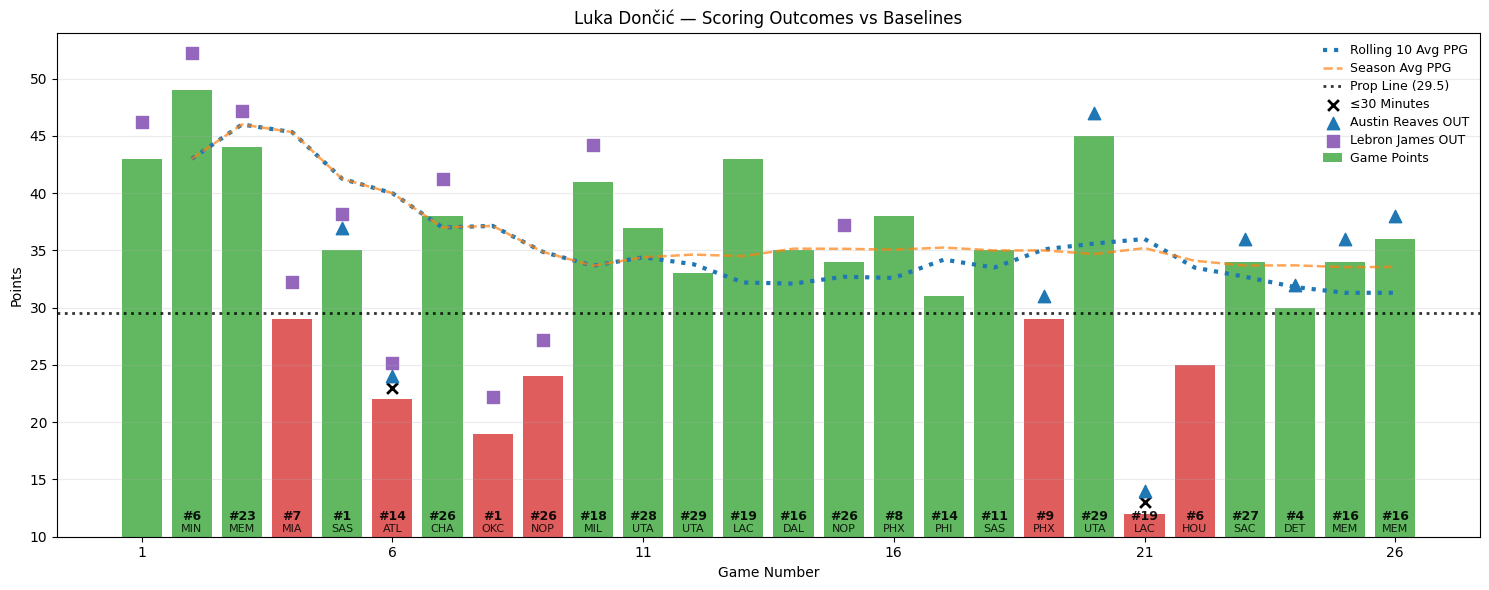

In [23]:
# PLOTTING CELL 2

def plot_player_scoring(player_id, prop_line, pbs, tbs, daily_ranks, teammate_ids=None):

    # =========================================================
    # 1) Prepare player plotting dataframe
    # =========================================================

    plot_df = pbs[pbs["personId"] == player_id]

    plot_df = (
        plot_df
        .sort_values(["game_date", "game_id"])
        .reset_index(drop=True)
    )

    plot_df["game_number"] = np.arange(1, len(plot_df) + 1)
    x = np.arange(len(plot_df))

    plot_df["game_date_dt"] = pd.to_datetime(plot_df["game_date"])

    # =========================================================
    # 2) Build opponent lookup from TEAM box scores
    # =========================================================

    opp_lookup = (
        tbs[["GAME_ID", "TEAM_ABBREVIATION"]]
        .rename(columns={
            "GAME_ID": "game_id",
            "TEAM_ABBREVIATION": "team"
        })
    )

    opp_lookup = (
        opp_lookup
        .merge(
            opp_lookup,
            on="game_id",
            suffixes=("", "_opp")
        )
        .query("team != team_opp")
        [["game_id", "team", "team_opp"]]
        .drop_duplicates()
        .rename(columns={"team_opp": "OPP_TEAM"})
    )

    team = plot_df["teamTricode"][0]

    plot_df = plot_df.merge(
        opp_lookup[opp_lookup["team"] == team][["game_id", "OPP_TEAM"]],
        on="game_id",
        how="left",
        validate="one_to_one"
    )

    # =========================================================
    # 3) AS-OF MERGE opponent defensive rank
    # =========================================================

    # Convert daily_ranks to match team_defense_daily structure
    daily_ranks_plot = daily_ranks.copy()
    daily_ranks_plot["as_of_date"] = pd.to_datetime(daily_ranks_plot["game_date"]) + pd.Timedelta(days=1)
    
    daily_ranks_plot = daily_ranks_plot.rename(
        columns={"TEAM_ABBREVIATION": "OPP_TEAM"}
    )

    plot_df = plot_df.sort_values("game_date_dt")
    daily_ranks_plot = daily_ranks_plot.sort_values("as_of_date")

    plot_df = pd.merge_asof(
        plot_df,
        daily_ranks_plot,
        left_on="game_date_dt",
        right_on="as_of_date",
        by="OPP_TEAM",
        direction="backward"
    )

    plot_df = plot_df.rename(columns={"def_rank": "opp_def_rank"})

    # =========================================================
    # 4) Bar colors (prop logic)
    # =========================================================

    bar_colors = np.where(
        plot_df["points"] >= prop_line,
        "tab:green",
        "tab:red"
    )

    # =========================================================
    # 5) Plot
    # =========================================================

    fig, ax = plt.subplots(figsize=(15, 6))

    ax.bar(
        x,
        plot_df["points"],
        color=bar_colors,
        alpha=0.75,
        label="Game Points"
    )

    ax.plot(
        x,
        plot_df["r10_avg_ppg"],
        linestyle=":",
        linewidth=3,
        label="Rolling 10 Avg PPG"
    )

    ax.plot(
        x,
        plot_df["szn_avg_ppg"],
        linestyle="--",
        linewidth=1.8,
        alpha=0.7,
        label="Season Avg PPG"
    )

    ax.axhline(
        prop_line,
        linestyle=":",
        linewidth=2,
        color="black",
        alpha=0.8,
        label=f"Prop Line ({prop_line})"
    )

    # =========================================================
    # 6) Low minutes marker (≤30)
    # =========================================================

    low_min_mask = plot_df["minutes"] <= 30

    ax.scatter(
        x[low_min_mask],
        plot_df.loc[low_min_mask, "points"] + 1,
        marker="x",
        color="black",
        s=60,
        linewidths=2,
        label="≤30 Minutes"
    )

    # =========================================================
    # 7) Teammate absence markers
    # =========================================================

    pbs_names = pbs.copy()
    pbs_names["firstName"] = pbs_names["firstName"].str.lower()
    pbs_names["familyName"] = pbs_names["familyName"].str.lower()

    player_game_ids = set(plot_df["game_id"])

    # Visual config (cycled if 2 teammates)
    markers = ["^", "s"]
    colors = ["tab:blue", "tab:purple"]
    y_offsets = [2.0, 3.2]

    if teammate_ids is not None:
        for i, teammate_id in enumerate(teammate_ids):
            if isinstance(teammate_id, str):
                # Name-based identification (e.g., "reaves")
                teammate_games = set(
                    pbs_names[
                        (pbs_names["familyName"] == teammate_id.lower()) &
                        (pbs_names["game_id"].isin(player_game_ids))
                    ]["game_id"]
                )
                out_col = f"teammate_{i}_out"
                plot_df[out_col] = ~plot_df["game_id"].isin(teammate_games)
                
                # Get teammate name for legend
                name_row = (
                    pbs_names[pbs_names["familyName"] == teammate_id.lower()]
                    [["firstName", "familyName"]]
                    .drop_duplicates()
                    .iloc[0]
                )
                teammate_name = f"{name_row['familyName'].title()}"
            else:
                # personId-based identification
                teammate_games = set(
                    pbs_names[
                        (pbs_names["personId"] == teammate_id) &
                        (pbs_names["game_id"].isin(player_game_ids))
                    ]["game_id"]
                )
                out_col = f"teammate_{i}_out"
                plot_df[out_col] = ~plot_df["game_id"].isin(teammate_games)
                
                # Get teammate name for legend
                name_row = (
                    pbs_names[pbs_names["personId"] == teammate_id]
                    [["firstName", "familyName"]]
                    .drop_duplicates()
                    .iloc[0]
                )
                teammate_name = f"{name_row['firstName'].title()} {name_row['familyName'].title()}"
            
            ax.scatter(
                x[plot_df[out_col]],
                plot_df.loc[plot_df[out_col], "points"] + y_offsets[i],
                marker=markers[i],
                color=colors[i],
                s=80 if i == 0 else 70,
                label=f"{teammate_name} OUT"
            )

    # =========================================================
    # 8) Opponent team + defensive rank labels (BOTTOM)
    # =========================================================

    for i, row in plot_df.iterrows():
        if not pd.isna(row["opp_def_rank"]):
            ax.text(
                i,
                10.2,
                f'{row["OPP_TEAM"]}',
                ha="center",
                va="bottom",
                fontsize=8,
                alpha=0.85
            )
            ax.text(
                i,
                11.2,
                f'#{int(row["opp_def_rank"])}',
                ha="center",
                va="bottom",
                fontsize=9,
                fontweight="bold",
                alpha=0.9
            )

    # =========================================================
    # 9) Formatting
    # =========================================================

    # Get player name for dynamic title
    player_name_row = (
        pbs[pbs["personId"] == player_id]
        [["firstName", "familyName"]]
        .drop_duplicates()
        .iloc[0]
    )
    player_name = f"{player_name_row['firstName']} {player_name_row['familyName']}"

    ax.set_ylim(10, plot_df["points"].max() + 5)
    ax.set_ylabel("Points")
    ax.set_xlabel("Game Number")
    ax.set_title(f"{player_name} — Scoring Outcomes vs Baselines")

    ax.set_xticks(x[::5])
    ax.set_xticklabels(plot_df["game_number"][::5])

    ax.grid(axis="y", alpha=0.25)
    ax.legend(
        fontsize=9,
        frameon=False,
        labelspacing=0.4,
        handlelength=1.5,
        handletextpad=0.6
    )

    plt.tight_layout()
    plt.show()

plot_player_scoring(1629029, 29.5, pbs, tbs, daily_ranks, [1630559, 2544])

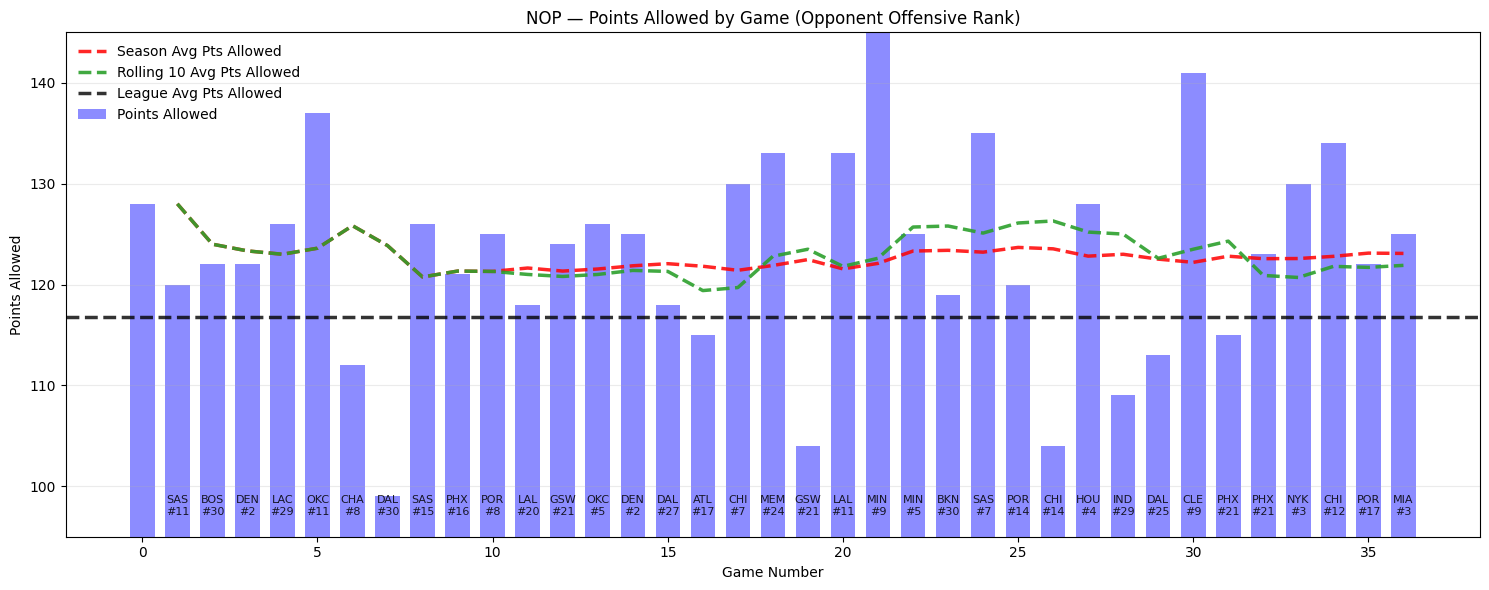

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'NOP — Points Allowed by Game (Opponent Offensive Rank)'}, xlabel='Game Number', ylabel='Points Allowed'>)

In [24]:
def plot_team_points_allowed(team_abbreviation, tbs, daily_ranks):
    """
    Plot a team's points allowed per game with season averages and opponent offensive ranks.
    
    Parameters:
    -----------
    team_abbreviation : str
        Team abbreviation (e.g., "NOP", "LAL")
    tbs : pd.DataFrame
        Team box scores dataframe
    daily_ranks : pd.DataFrame
        Daily team rankings dataframe with offensive ranks
    """
    
    # =========================================================
    # 1) Prep team box scores
    # =========================================================
    
    tbs_plot = tbs.copy()
    tbs_plot["GAME_DATE_DT"] = pd.to_datetime(tbs_plot["GAME_DATE"])
    
    team_games = (
        tbs_plot[tbs_plot["TEAM_ABBREVIATION"] == team_abbreviation]
        .sort_values("GAME_DATE_DT")
        .reset_index(drop=True)
    )
    
    # Opponent abbreviation
    team_games["OPP_TEAM"] = team_games["MATCHUP"].str[-3:]
    
    # =========================================================
    # 2) Season-to-date avg points allowed (NO leakage)
    # =========================================================
    
    team_games["szn_avg_pts_allowed"] = (
        team_games["PTS_ALLOWED"]
        .shift(1)                    # only prior games
        .expanding()
        .mean()
    )
    
    # Rolling 10-game avg points allowed (prior games only)
    team_games["r10_avg_pts_allowed"] = (
        team_games["PTS_ALLOWED"]
        .shift(1)
        .rolling(10, min_periods=1)
        .mean()
    )
    
    # League-wide avg points allowed
    league_avg_pts_allowed = (
        tbs[tbs["GAME_DATE"] <= team_games["GAME_DATE"].max()]
        ["PTS_ALLOWED"]
        .mean()
    )
    
    # =========================================================
    # 3) Attach opponent OFFENSIVE rank (as of game date)
    # =========================================================
    
    daily_ranks_plot = daily_ranks.copy()
    daily_ranks_plot["game_date_dt"] = pd.to_datetime(daily_ranks_plot["game_date"])
    
    team_games = team_games.sort_values("GAME_DATE_DT")
    daily_ranks_plot = daily_ranks_plot.sort_values("game_date_dt")
    
    team_games = pd.merge_asof(
        team_games,
        daily_ranks_plot,
        left_on="GAME_DATE_DT",
        right_on="game_date_dt",
        left_by="OPP_TEAM",
        right_by="TEAM_ABBREVIATION",
        direction="backward"
    )
    
    # =========================================================
    # 4) Plot
    # =========================================================
    
    x = np.arange(len(team_games))
    
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # -----------------------------
    # Bars: points allowed
    # -----------------------------
    ax.bar(
        x,
        team_games["PTS_ALLOWED"],
        width=0.7,
        color="blue",
        alpha=0.45,
        label="Points Allowed"
    )
    
    
    # -----------------------------
    # Season avg line
    # -----------------------------
    ax.plot(
        x,
        team_games["szn_avg_pts_allowed"],
        linestyle="--",
        linewidth=2.5,
        color="red",
        alpha=0.85,
        label="Season Avg Pts Allowed"
    )
    
    
    # Rolling 10 avg line
    ax.plot(
        x,
        team_games["r10_avg_pts_allowed"],
        linestyle="--",
        linewidth=2.5,
        color="tab:green",
        alpha=0.9,
        label="Rolling 10 Avg Pts Allowed"
    )
    
    # League-wide avg line
    ax.axhline(
        league_avg_pts_allowed,
        linestyle="--",
        linewidth=2.5,
        color="black",
        alpha=0.8,
        label="League Avg Pts Allowed"
    )
    
    # -----------------------------
    # Bottom labels: opponent + off rank
    # -----------------------------
    for i, row in team_games.iterrows():
        if pd.notna(row["off_rank"]):
            ax.text(
                i,
                97,
                f'{row["OPP_TEAM"]}\n#{int(row["off_rank"])}',
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
                alpha=0.85
            )
    
    # -----------------------------
    # Formatting
    # -----------------------------
    ax.set_title(f"{team_abbreviation} — Points Allowed by Game (Opponent Offensive Rank)")
    ax.set_ylabel("Points Allowed")
    ax.set_xlabel("Game Number")
    
    # ax.set_ylim(80, team_games["PTS_ALLOWED"].max() + 5)
    ax.set_ylim(95, 145)
    
    # ax.set_xticks(x[::5])
    # ax.set_xticklabels(x[::5] + 1)
    
    ax.grid(axis="y", alpha=0.25)
    ax.legend(
        loc="upper left",
        frameon=False,
        fontsize=10
    )
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

plot_team_points_allowed("NOP", tbs, daily_ranks)

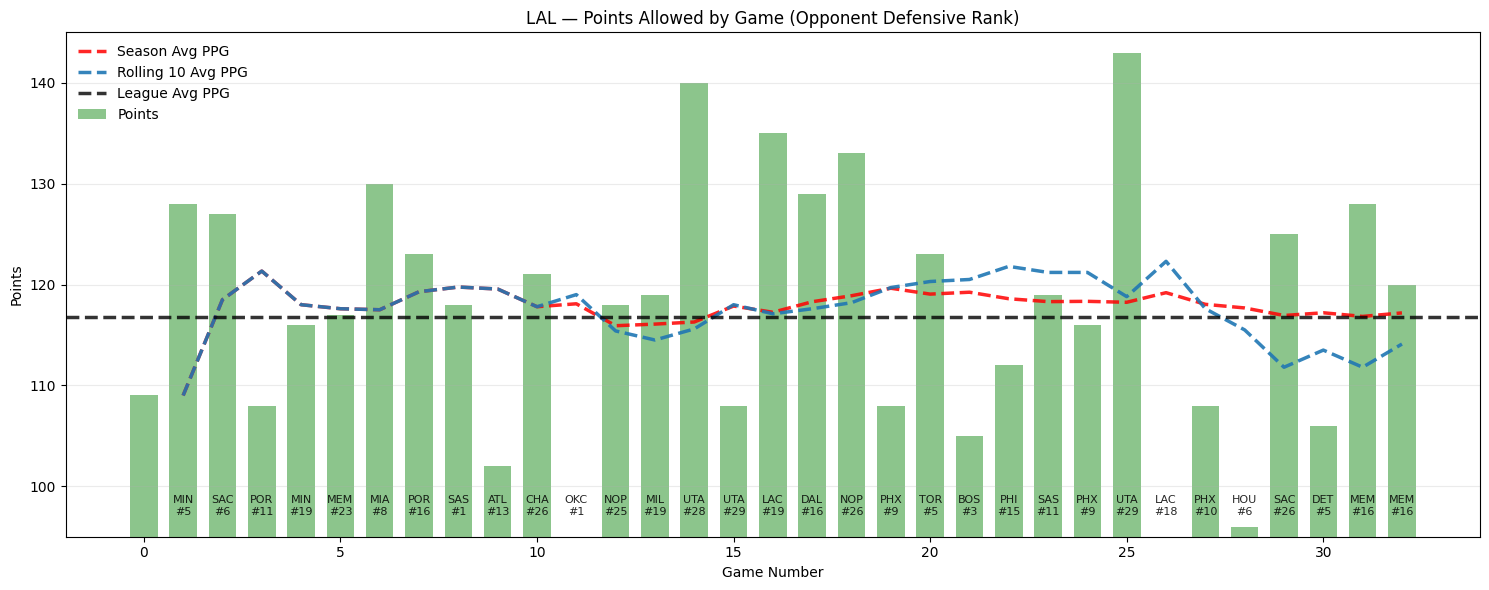

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'LAL — Points Allowed by Game (Opponent Defensive Rank)'}, xlabel='Game Number', ylabel='Points'>)

In [ ]:
def plot_team_points_scored(team_abbreviation, tbs, daily_ranks):
    
    # =========================================================
    # 1) Prep team box scores
    # =========================================================
    
    tbs_plot = tbs.copy()
    tbs_plot["GAME_DATE_DT"] = pd.to_datetime(tbs_plot["GAME_DATE"])
    
    team_games = (
        tbs_plot[tbs_plot["TEAM_ABBREVIATION"] == team_abbreviation]
        .sort_values("GAME_DATE_DT")
        .reset_index(drop=True)
    )
    
    # Opponent abbreviation
    team_games["OPP_TEAM"] = team_games["MATCHUP"].str[-3:]
    
    # =========================================================
    # 2) Season-to-date avg points (NO leakage)
    # =========================================================
    
    team_games["szn_avg_ppg"] = (
        team_games["PTS"]
        .shift(1)                    # only prior games
        .expanding()
        .mean()
    )
    
    # Rolling 10-game avg points (prior games only)
    team_games["r10_avg_ppg"] = (
        team_games["PTS"]
        .shift(1)
        .rolling(10, min_periods=1)
        .mean()
    )
    
    # League-wide avg points 
    league_avg_ppg = (
        tbs[tbs["GAME_DATE"] <= team_games["GAME_DATE"].max()]
        ["PTS"]
        .mean()
    )
    
    # =========================================================
    # 3) Attach opponent OFFENSIVE rank (as of game date)
    # =========================================================
    
    daily_ranks_plot = daily_ranks.copy()
    daily_ranks_plot["game_date_dt"] = pd.to_datetime(daily_ranks_plot["game_date"])
    
    team_games = team_games.sort_values("GAME_DATE_DT")
    daily_ranks_plot = daily_ranks_plot.sort_values("game_date_dt")
    
    team_games = pd.merge_asof(
        team_games,
        daily_ranks_plot,
        left_on="GAME_DATE_DT",
        right_on="game_date_dt",
        left_by="OPP_TEAM",
        right_by="TEAM_ABBREVIATION",
        direction="backward"
    )
    
    # =========================================================
    # 4) Plot
    # =========================================================
    
    x = np.arange(len(team_games))
    
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # -----------------------------
    # Bars: points allowed
    # -----------------------------
    ax.bar(
        x,
        team_games["PTS"],
        width=0.7,
        color="green",
        alpha=0.45,
        label="Points"
    )
    
    
    # -----------------------------
    # Season avg line
    # -----------------------------
    ax.plot(
        x,
        team_games["szn_avg_ppg"],
        linestyle="--",
        linewidth=2.5,
        color="red",
        alpha=0.85,
        label="Season Avg PPG"
    )
    
    
    # Rolling 10 avg line
    ax.plot(
        x,
        team_games["r10_avg_ppg"],
        linestyle="--",
        linewidth=2.5,
        color="tab:blue",
        alpha=0.9,
        label="Rolling 10 Avg PPG"
    )
    
    # League-wide avg line
    ax.axhline(
        league_avg_ppg,
        linestyle="--",
        linewidth=2.5,
        color="black",
        alpha=0.8,
        label="League Avg PPG"
    )
    
    # -----------------------------
    # Bottom labels: opponent + off rank
    # -----------------------------
    for i, row in team_games.iterrows():
        if pd.notna(row["def_rank"]):
            ax.text(
                i,
                97,
                f'{row["OPP_TEAM"]}\n#{int(row["def_rank"])}',
                ha="center",
                va="bottom",
                fontsize=8,
                color="black",
                alpha=0.85
            )
    
    # -----------------------------
    # Formatting
    # -----------------------------
    ax.set_title(f"{team_abbreviation} — Points Scored by Game (Opponent Defensive Rank)")
    ax.set_ylabel("Points")
    ax.set_xlabel("Game Number")
    
    # ax.set_ylim(80, team_games["PTS_ALLOWED"].max() + 5)
    ax.set_ylim(95, 145)
    
    # ax.set_xticks(x[::5])
    # ax.set_xticklabels(x[::5] + 1)
    
    ax.grid(axis="y", alpha=0.25)
    ax.legend(
        loc="upper left",
        frameon=False,
        fontsize=10
    )
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax

plot_team_points_scored("LAL", tbs, daily_ranks)